In [1]:
%matplotlib notebook
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from os import path
import numpy as np
import cv2 as cv
import trimesh
import sys
import os

# Required to import local modules
repo_root = path.abspath(path.join('..', '..'))
if repo_root not in sys.path:
    sys.path.append(repo_root)

# Our local modules
import ds_tools.shared.mesh_util as mesh_util
import ds_tools.shared.plot_util as plot_util
import ds_tools.calibration.calibrate as clb
import ds_tools.calibration.render as render
import ds_tools.shared.transform as tf
import ds_tools.shared.util as util

# Overview

Here we generate a 3D render based on the calibrated camera intrinsics and extrinsics.

# Load endoscope marker meshes from the phantom CT scan

In [2]:
data_dir = util.get_data_dir()
capture_dir = path.join(data_dir, 'placenta_phantom')
phantom_scene_dir = path.join(capture_dir, 'placenta_scene')
endo_phantom_image_file = path.join(phantom_scene_dir, 'scan_6_rectified.png')
endo_phantom_model_file = path.join(phantom_scene_dir, 'placenta_mesh.stl')
endo_phantom_markers_file = path.join(phantom_scene_dir, 'endo_markers.stl')
endo_phantom_markers_joint = trimesh.load(endo_phantom_markers_file)

phantom_centroids = mesh_util.extract_marker_mesh_centroids(endo_phantom_markers_joint)
phantom_points_3d = np.array(phantom_centroids).T

# Load our camera intrinsics/extrinsics estimates

In [3]:
intrinsics_file = path.join(data_dir, 'intrinsics.json')
cam_matrix, dist_coeffs, width, height = util.load_intrinsics(intrinsics_file)
extrinsics_file = path.join(data_dir, 'extrinsics.json')
T_rigid_to_cam, endoscope_markers = util.load_extrinsics(extrinsics_file)

new_cam_matrix, roi = cv.getOptimalNewCameraMatrix(cam_matrix, dist_coeffs,
                                                   (width, height), 1, (width, height))

# Find transform from world to our calibration reference frame

In [4]:
T_world_to_rigid = clb.calc_rigid_body_transform(phantom_points_3d, endoscope_markers)

# Find transform from world to camera frame and visualise it

<IPython.core.display.Javascript object>


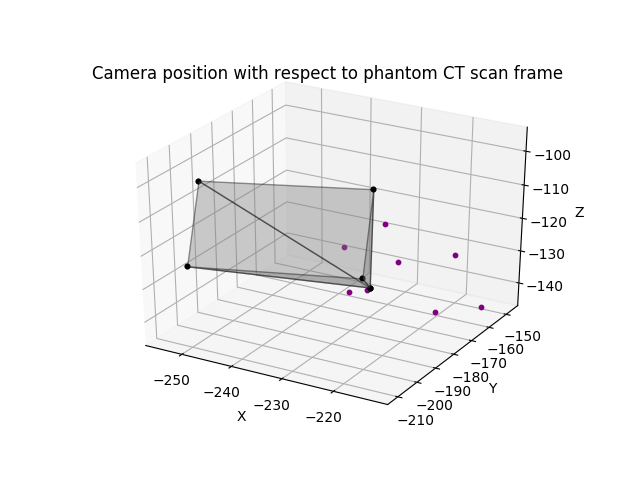

In [5]:
T_world_to_cam = T_rigid_to_cam @ T_world_to_rigid
T_cam_to_world = np.linalg.inv(T_world_to_cam)

_, ax = plot_util.prepare_3d_plot(title='Camera position with respect to phantom CT scan frame')
plot_util.draw_3d_points(ax, phantom_points_3d, colour='purple')
plot_util.draw_3d_camera(ax, width, height, new_cam_matrix, T_cam_to_world, z=40)

# Generate 3D render

In [6]:
print('Parameters for 3D render:')
print('Width, height: {}, {}'.format(width, height))
print('Camera to world transform:')
print(repr(np.round(T_cam_to_world, 4)))
print('Camera matrix:')
print(np.round(new_cam_matrix, 2))
print('')

rendered_image = render.generate_render(
    width=width, height=height,
    T_cam_to_world=T_cam_to_world, cam_matrix=new_cam_matrix,
    phantom_model_path=endo_phantom_model_file,
    endoscope_markers_path=endo_phantom_markers_file
)
rendered_image = cv.cvtColor(rendered_image, cv.COLOR_BGR2RGB)

print('Render shape:', rendered_image.shape)

phantom_scene_data = {
    'cam_to_world_transform': T_cam_to_world.tolist(),
    'camera_matrix': new_cam_matrix.tolist(),
    'width': width,
    'height': height,
}
phantom_scene_json = path.join(data_dir, 'phantom_scene.json')
util.save_dict(phantom_scene_json, phantom_scene_data)

Parameters for 3D render:
Width, height: 720, 576
Camera to world transform:
array([[-9.734000e-01,  1.705000e-01, -1.533000e-01, -2.287531e+02],
       [ 3.000000e-04, -6.675000e-01, -7.446000e-01, -1.733416e+02],
       [-2.293000e-01, -7.248000e-01,  6.496000e-01, -1.360397e+02],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])
Camera matrix:
[[829.42   0.   353.41]
 [  0.   936.29 312.53]
 [  0.     0.     1.  ]]



Camera HPR: [167.18125915527344, 41.801822662353516, 18.32822608947754]
Camera pos: [-228.75306701660156, -173.341552734375, -136.0397491455078]
Camera film size: LVecBase2f(1, 0.708689)
Camera focal length: 1.1519770622253418
Render shape: (576, 720, 3)


# Overlay the 3D render over original image

<IPython.core.display.Javascript object>


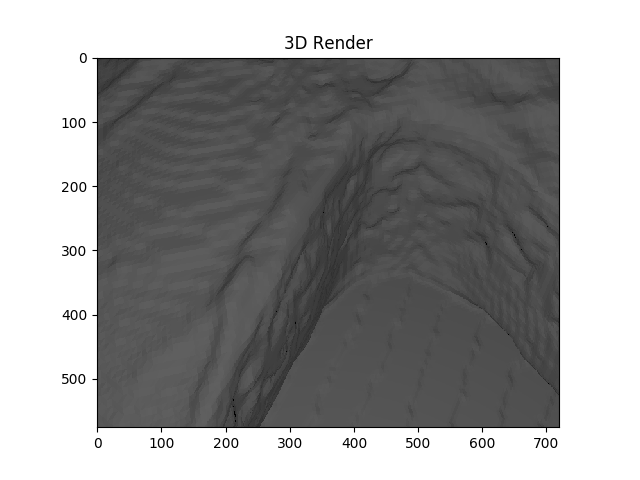

<IPython.core.display.Javascript object>


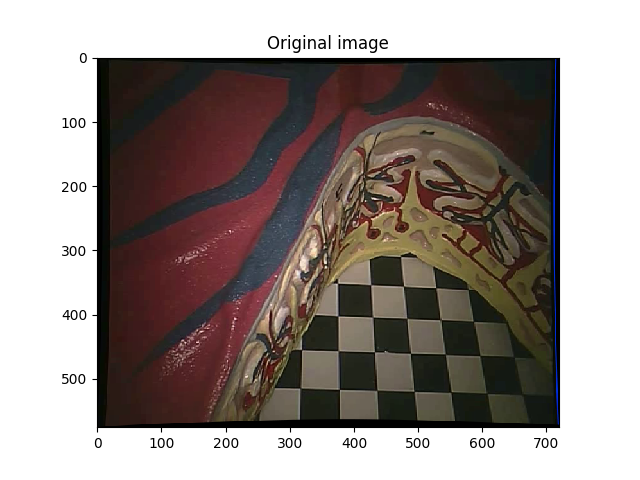

<IPython.core.display.Javascript object>


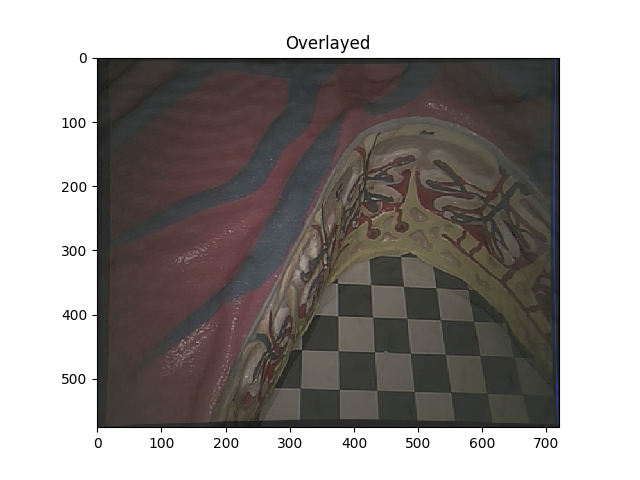

In [7]:
actual_image = cv.imread(endo_phantom_image_file)
actual_image = cv.cvtColor(actual_image, cv.COLOR_BGR2RGB)
overlayed = cv.addWeighted(actual_image, 0.5, rendered_image, 0.5, 0.0)

titles = ['3D Render', 'Original image', 'Overlayed']
images= [rendered_image, actual_image, overlayed]
for i in range(len(images)):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.set_title(titles[i])
    ax.imshow(images[i])